<a href="https://colab.research.google.com/github/Ankush-kadu/MEDISCAN-AI-MOBILE-AI-FOR-RAPID-PNEUMONIA-DETECTION/blob/main/MEDISCAN_AI_CNN_for_Medical_Diagnosis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing required libraries

import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
#tf.distribute.Strategy is a TensorFlow API to distribute training across multiple GPUs,
#multiple machines, or TPUs. Using this API, you can distribute your existing models and
#training code with minimal code changes.
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

# Specifying our training batch size
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

# Specifying the image size
IMAGE_SIZE = [224, 224]

# List containing class names, which will be used to index on our model output
# 0 = NORMAL, 1 = PNEUMONIA
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [4]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [5]:
COUNT_NORMAL = len([filename for filename in train_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

print('Total Count of images:', COUNT_NORMAL+COUNT_PNEUMONIA )

Normal images count in training set: 1349
Pneumonia images count in training set: 3883
Total Count of images: 5232


In [6]:
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT)  / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls = AUTOTUNE)

Let's split the data into a training and validation datasets.

In [8]:
ds = ds.shuffle(10000)
train_ds = ds.take(4300)
val_ds = ds.skip(4300)

Let's visualize the shape of an (image, label) pair.

In [9]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (224, 224, 3)


Load and format the test data as well.

In [10]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)

COUNT_NORMAL = len([filename for filename in test_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in test set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in test_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in test set: " + str(COUNT_PNEUMONIA))

Normal images count in test set: 234
Pneumonia images count in test set: 390


In [11]:
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_batch = test_ds.batch(BATCH_SIZE)

## Visualize the dataset



In [12]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.

    ds = ds.cache()
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Call the next batch iteration of the training data.

In [13]:
train_ds_batch = prepare_for_training(train_ds)
val_ds_batch = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds_batch))

Define the method to show the images in the batch.

In [14]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

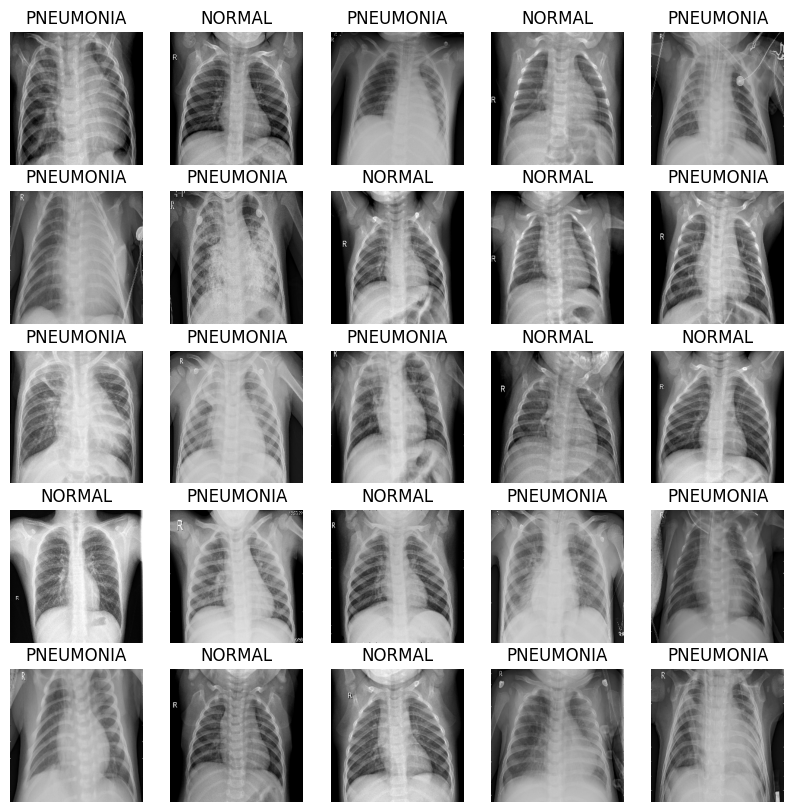

In [15]:
show_batch(image_batch.numpy(), label_batch.numpy())

### MobileNet Architecture :



In [16]:
import tensorflow as tf

#import all necessary layers
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense

from tensorflow.keras import Model

In [17]:
# MobileNet block
def mobilnet_block (x, filters, strides):

    x = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x

In [18]:
#stem of the model
input = Input(shape = (224, 224, 3))
x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

In [19]:
# main part of the model
x = mobilnet_block(x, filters = 64, strides = 1)
x = mobilnet_block(x, filters = 128, strides = 2)
x = mobilnet_block(x, filters = 128, strides = 1)
x = mobilnet_block(x, filters = 256, strides = 2)
x = mobilnet_block(x, filters = 256, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 2)
for _ in range (5):
     x = mobilnet_block(x, filters = 512, strides = 1)
x = mobilnet_block(x, filters = 1024, strides = 2)
x = mobilnet_block(x, filters = 1024, strides = 1)
x = AvgPool2D (pool_size = 7, strides = 1, data_format='channels_first')(x)
output = Dense (units = 1000, activation = 'softmax')(x)
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 32)      320       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      128   

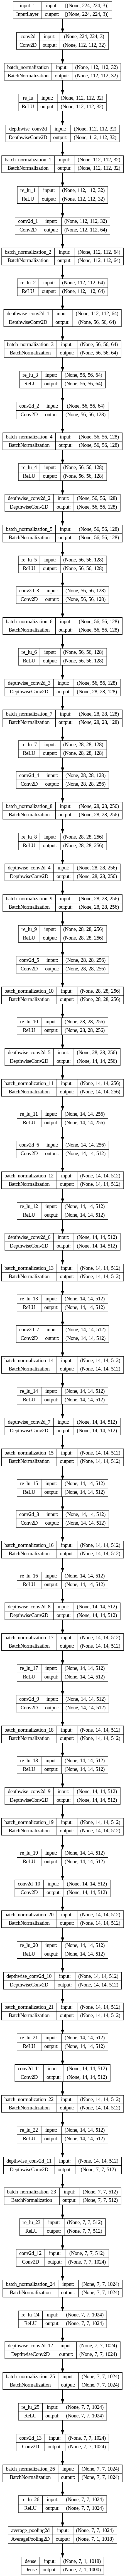

In [20]:
#plot the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [21]:
# def build_model():

#     mobilenet_model = tf.keras.applications.MobileNetV2(
#         weights ='imagenet',
#         include_top = False,
#         input_shape = (224,224,3)
#     )

#     #Freezing the pretrained mobilenet layers except the last  layer
#     # Known as fintuning the model

#     for layer in mobilenet_model.layers[:-2]:
#         layer.trainable = False


#     # for layer in mobilenet_model.layers:
#     #     layer.trainable = False


#     #Output of base model
#     x = mobilenet_model.output
#     x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dense(128, activation = "relu")(x)
#     output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
#     pretrained_model = tf.keras.Model(inputs = mobilenet_model.input, outputs = output)

#     return pretrained_model

In [22]:
import tensorflow as tf

def build_model():
    mobilenet_model = tf.keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the pretrained MobileNetV2 layers except the last two layers
    for layer in mobilenet_model.layers[:-2]:
        layer.trainable = False

    # Output of the base model
    x = mobilenet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Adding Dropout
    x = tf.keras.layers.Dropout(0.5)(x)  # Adjust dropout rate as needed

    x = tf.keras.layers.Dense(128, activation="relu")(x)

    # Adding another Dropout
    x = tf.keras.layers.Dropout(0.5)(x)  # Adjust dropout rate as needed

    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    pretrained_model = tf.keras.Model(inputs=mobilenet_model.input, outputs=output)

    return pretrained_model


In [23]:
finetuned_mobilenet = build_model()

9406464/9406464 [==============================] - 0s 0us/step


In [24]:
# Visualizing our model layers and parameters
finetuned_mobilenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [25]:
# from google.colab import drive
# drive.mount('/content/gdrive/',force_remount=True)

In [26]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
)

In [27]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [28]:
initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [29]:
print(train_ds_batch.element_spec)


(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.bool, name=None))


In [30]:
train_ds_batch = train_ds_batch.map(lambda x, y: (x, tf.cast(y, tf.float32)))
val_ds_batch = val_ds_batch.map(lambda x, y: (x, tf.cast(y, tf.float32)))


### Training the model:

In [31]:
with strategy.scope():
  finetuned_mobilenet = build_model()
  METRICS = [
  tf.keras.metrics.BinaryAccuracy(),
  tf.keras.metrics.Precision(name="precision"),
  tf.keras.metrics.Recall(name="recall"),
  ]
  finetuned_mobilenet.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss="binary_crossentropy",
  metrics=METRICS,
  )

  history = finetuned_mobilenet.fit(
  train_ds_batch,
  epochs = 30,
  validation_data = val_ds_batch,
  class_weight = class_weight,
  callbacks=[checkpoint_cb,lr_scheduler]
  )

Epoch 1/30
135/135 [==============================] - 113s 425ms/step - loss: 0.4798 - binary_accuracy: 0.8500 - precision: 0.9529 - recall: 0.8402 - val_loss: 0.2068 - val_binary_accuracy: 0.9206 - val_precision: 0.9285 - val_recall: 0.9684 - lr: 0.0100
Epoch 2/30
135/135 [==============================] - 7s 54ms/step - loss: 0.2503 - binary_accuracy: 0.8988 - precision: 0.9743 - recall: 0.8877 - val_loss: 0.2411 - val_binary_accuracy: 0.8745 - val_precision: 0.8580 - val_recall: 0.9971 - lr: 0.0089
Epoch 3/30
135/135 [==============================] - 8s 57ms/step - loss: 0.2515 - binary_accuracy: 0.8886 - precision: 0.9710 - recall: 0.8768 - val_loss: 0.2066 - val_binary_accuracy: 0.9013 - val_precision: 0.8893 - val_recall: 0.9914 - lr: 0.0079
Epoch 4/30
135/135 [==============================] - 8s 57ms/step - loss: 0.2382 - binary_accuracy: 0.8967 - precision: 0.9710 - recall: 0.8880 - val_loss: 0.1762 - val_binary_accuracy: 0.9249 - val_precision: 0.9130 - val_recall: 0.9943 - 

## Plotting model performance

Let's plot the model accuracy and loss for the training and the validating set. Note that
no random seed is specified for this notebook. For your notebook, there might be slight
variance.

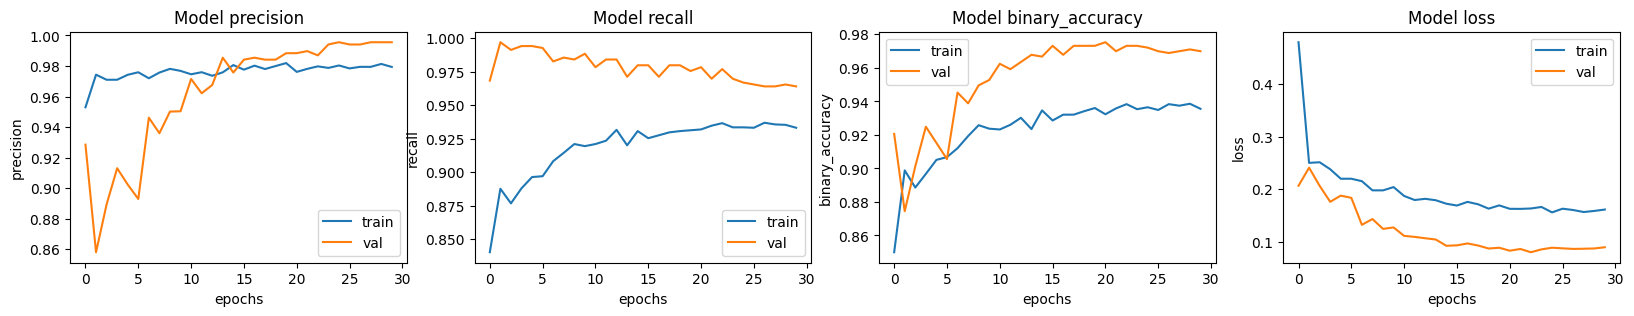

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

### Loading the Model



In [33]:
loaded_mobilenet = tf.keras.models.load_model('xray_model.h5')

## Evaluate model



In [34]:
loaded_mobilenet.evaluate(test_ds_batch, return_dict=True)

20/20 [==============================] - 10s 378ms/step - loss: 0.5392 - binary_accuracy: 0.7965 - precision: 0.7657 - recall: 0.9718


{'loss': 0.5392118096351624,
 'binary_accuracy': 0.7964743375778198,
 'precision': 0.765656590461731,
 'recall': 0.971794843673706}

Predicting on a test image using our trained MobileNet Model

2/2 [==============================] - 2s 432ms/step
This image is 85.85 percent NORMAL
This image is 14.15 percent PNEUMONIA
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


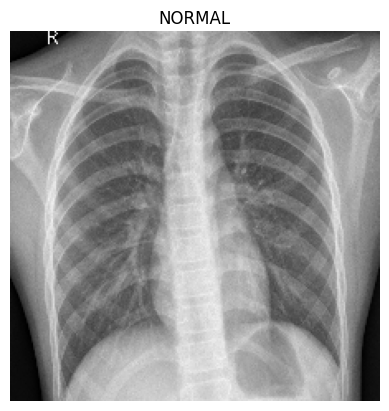

In [35]:
for image, label in test_ds_batch.take(2):
      plt.imshow(image[2] / 255.0)
      plt.title(CLASS_NAMES[label[2].numpy()])
      plt.axis('off')
prediction = finetuned_mobilenet.predict(test_ds_batch.take(2))[2]
scores = [1 - prediction, prediction]
for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))
%time

## Confusion Matrix

In [36]:
label_list = []
prediction_list = []

for image, label in test_ds:
    image = tf.expand_dims(image, axis = 0)
    prediction = finetuned_mobilenet.predict(image)
    label = tf.where(label, 1, 0)

    if prediction > 0.5 :
        prediction = 1
    else :
        prediction = 0

    prediction_list.append(prediction)
    label_list.append(label)

1/1 [==============================] - 0s 33ms/step


In [37]:
test_confusion_matrix = tf.math.confusion_matrix(label_list, prediction_list)

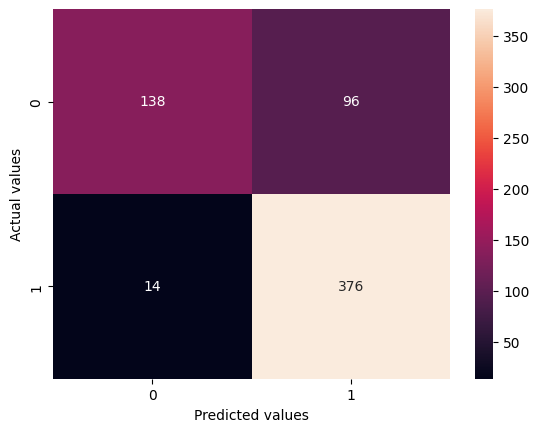

In [38]:
ax = sns.heatmap(test_confusion_matrix, annot = True, fmt ='g')
ax.set(xlabel = 'Predicted values', ylabel = 'Actual values')

plt.show()

# GRADCAM


Since I need the last Convolution layer for implementing our GRADCAM Algorithm, </br>
I print every Conv. layer name in My pretrained_modbilenet model

In [39]:
for i in range(len(finetuned_mobilenet.layers)):
    layer = finetuned_mobilenet.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i , layer.name , layer.output.shape)

4 expanded_conv_depthwise (None, 112, 112, 32)
5 expanded_conv_depthwise_BN (None, 112, 112, 32)
6 expanded_conv_depthwise_relu (None, 112, 112, 32)
7 expanded_conv_project (None, 112, 112, 16)
8 expanded_conv_project_BN (None, 112, 112, 16)


Last convolutional layer for GRADCAM is expanded_conv_project_BN

In [40]:
last_conv_layer_name = finetuned_mobilenet.layers[8].name
last_conv_layer_name

'expanded_conv_project_BN'

In [41]:
!pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00


2/2 [==============================] - 2s 707ms/step
This image is 85.85 percent NORMAL
This image is 14.15 percent PNEUMONIA


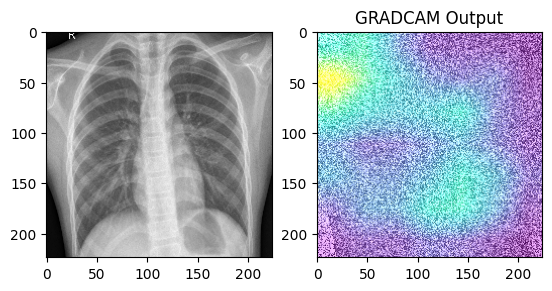

In [42]:
from tf_explain.core.grad_cam import GradCAM
import random

for image, label in test_ds_batch.take(2):

    data = ([image[2].numpy()], None)
    # print('Original label',CLASS_NAMES[label[2].numpy()])
    image = image[2] / 255

prediction = finetuned_mobilenet.predict(test_ds_batch.take(2))[2]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, finetuned_mobilenet,class_index = 0)

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(image)
axarr[1].imshow(grid)
# axarr[0].title.set_text(f"{float(prediction)*100:.2f}% penumonia predicted")
axarr[1].title.set_text('GRADCAM Output')
plt.show()

### Loading pretrained efficientnet:
https://keras.io/api/applications/efficientnet/

In [ ]:
with strategy.scope():
    pretrained_model = tf.keras.applications.EfficientNetB6(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # fine-tuning

    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.efficientnet.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

165234480/165234480 [==============================] - 7s 0us/step


## Beyond Convolution: The Transformer Architecture



- **The Vision Transformer (ViT) model** adapts the Transformer idea to work on images.
- The equivalent of words in images are square patches, so the first step is to take the input image and break it into patches,

In [ ]:
patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
)

<img src=https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/047/000/original/Screenshot_2023-09-08_at_12.23.45_PM.png?1694156046 width=800>

- Here if you observed The input image is broken into patches that are treated as the sequence input to the Transformer.
- The patches are represented by concatenating the patch pixel values and the patch position within the image:
   

In [ ]:
encoded = (tf.keras.layers.Dense(...)(patch) +
               tf.keras.layers.Embedding(...)(position))

- Note that the patch position is the ordinal number (5th, 6th, etc.) of the patch and is treated as a categorical variable.
- A learnable embedding is employed to capture close‐ ness relationships between patches that have related content.
- The patch representation is passed through multiple transformer blocks, each of which consists of an attention head (to learn which parts of the input to focus on)

In [ ]:

x1 = tf.keras.layers.LayerNormalization()(encoded)
#Just for sake of basic overview
attention_output = tf.keras.layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=projection_dim, dropout=0.1
)(x1, x1)

The attention output is used to add emphasis to the patch representation:

In [ ]:

# Skip connection 1.
x2 = tf.keras.layers.Add()([attention_output, encoded])
x3 = tf.keras.layers.LayerNormalization()(x2)# Layer normalization 2.



and passed through a set of dense layers:

In [ ]:

# multilayer perceptron (mlp), a set of dense layers.
x3 = mlp(x3, hidden_units=transformer_units,
          dropout_rate=0.1)
# Skip connection 2 forms input to next block
encoded = tf.keras.layers.Add()([x3, x2])